# Scanner walkthrough

To explore how Scanner works, we're going to walk through a simple video analysis application. If you want to analyze a film, a common unit of analysis is the _shot_, short segments of video often delineated by the camera cutting to a different angle or location. In this walkthrough, we're going to use Scanner to implement _shot segmentation_, or breaking up a video into shots. To start, we need to get a video. We'll use the trailer for Arrival:

In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/tFMo3UJ4B4g" frameborder="0" allowfullscreen></iframe>

We've set up some scripts to help you download the video in the snippet below.

[youtube] tFMo3UJ4B4g: Downloading webpage
[youtube] tFMo3UJ4B4g: Downloading video info webpage
[youtube] tFMo3UJ4B4g: Extracting video information
[youtube] tFMo3UJ4B4g: Downloading MPD manifest


[download] Destination: /tmp/example.mp4
[download] 100% of 4.15MiB in 00:0028MiB/s ETA 00:004
/tmp/example.mp4


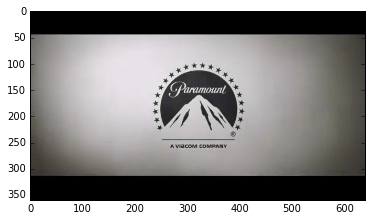

In [2]:
import util
path = util.download_video()
print path

# Display the 10th frame in the video
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
video = cv2.VideoCapture(path)
frames = []
while True:
    ret, frame = video.read()
    if not ret: break
    frames.append(frame)

plt.imshow(frames[10])
video.release()

Take another look at the video and see if you can identify when shots change. Our shot segmentation algorithm uses the following intuition: in a video, most frames are similar to the one following it. Because most shot changes happen with cuts (as opposed to dissolves or fades), there's an immediate visual break from one frame to the next. We want to identify when the change in visual content between two adjacent frames is substantially larger than normal. One way to estimate change in visual content is by computing a histogram of colors for each frame, i.e. count the number of dark pixels and light pixels in each color channel (red/green/blue), and then compute the magnitude of difference between adjacent frames' histograms. Let's visualize this for the above video:

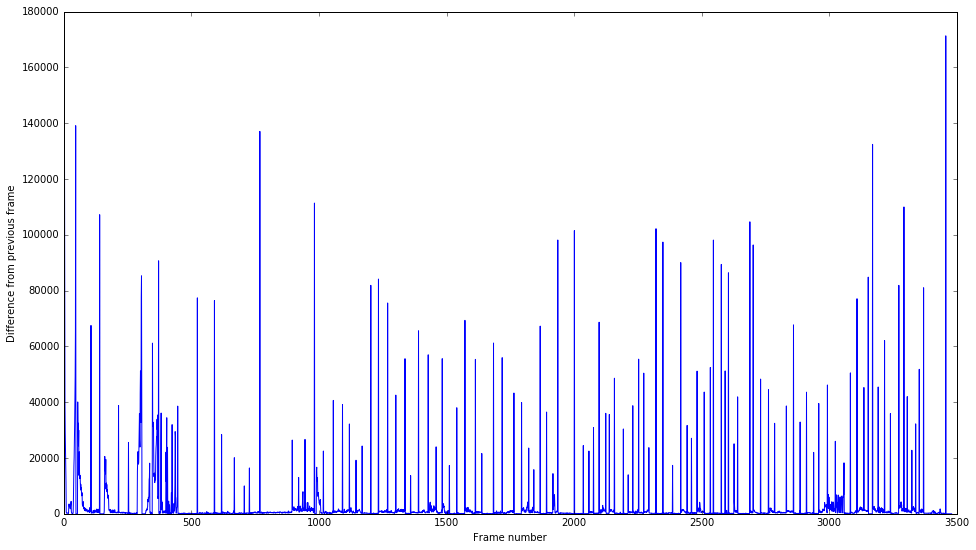

In [3]:
import numpy as np
from scipy.spatial import distance

histograms = []
N = len(frames)

# Compute 3 color histograms (one for each channel) for each video frame
for frame in frames:
    hists = [cv2.calcHist([frame], [channel], None, [16], [0, 256]) 
             for channel in range(3)]
    histograms.append(hists)

# Compute differences between adjacent pairs of histograms
diffs = []        
for i in range(1, N):
    frame_diffs = [distance.chebyshev(histograms[i-1][channel], histograms[i][channel]) 
                   for channel in range(3)]
    avg_diff = np.mean(frame_diffs)
    diffs.append(avg_diff)

# Plot the differences
plt.rcParams["figure.figsize"] = [16, 9]
plt.xlabel("Frame number")
plt.ylabel("Difference from previous frame")
plt.plot(range(1, N), diffs)

This plot shows, for each frame, the difference between its color histograms and the previous frame's color histograms. Try playing around with the number of histogram bins as well as the [distance metric](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html). As you can see, there are a number of sharp peaks interspersed throughout the video that likely correspond to shot boundaries. We can run a sliding window over the above graph to find the peaks:

Shot boundaries are:
[2, 3, 45, 46, 106, 140, 300, 303, 304, 347, 371, 523, 590, 768, 982, 1056, 1092, 1119, 1203, 1233, 1269, 1301, 1337, 1390, 1428, 1483, 1540, 1572, 1613, 1684, 1718, 1764, 1794, 1867, 1892, 1936, 2001, 2098, 2124, 2138, 2158, 2230, 2253, 2273, 2321, 2348, 2418, 2482, 2510, 2534, 2546, 2577, 2592, 2605, 2641, 2689, 2702, 2731, 2762, 2860, 2911, 2993, 3083, 3109, 3136, 3153, 3170, 3192, 3217, 3273, 3293, 3306, 3353, 3370, 3457]


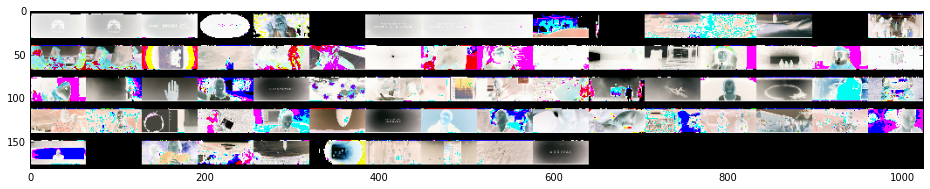

In [4]:
WINDOW_SIZE = 500  # The size of our sliding window (how many data points to include)
OUTLIER_STDDEV = 3 # Outliers are N standard deviations away from the mean of the sliding window
boundaries = []
for i in range(1, N):
    window = diffs[max(i-WINDOW_SIZE,0):min(i+WINDOW_SIZE,N)]
    if diffs[i-1] - np.mean(window) > OUTLIER_STDDEV * np.std(window):
        boundaries.append(i)

print 'Shot boundaries are:'
print boundaries

montage = util.make_montage([frames[i] for i in boundaries])
plt.imshow(montage)

And we've done it! The video is now segmented in shots. At this point, you're probably wondering: "...but I thought this was a Scanner tutorial!" Well, consider now: what if you wanted to run this pipeline over a second trailer? A movie? A thousand movies? The simple Python code we wrote above is great for experimenting, but doesn't scale. To accelerate this analysis, we need to speed up the core computation, computing the color histogram. Here are some ways we can make that faster:

* Use a faster histogram implementation, e.g. using the GPU.
* Use a faster video decoder, e.g. the hardware decoder.
* Parallelize the histogram pipeline on multiple CPUs or GPUs.
* Parallelize the histogram pipeline across a cluster of machines.

All of that is fairly difficult to do with Python, but easy with Scanner. 

Now I'm going to walk you through running the histogram computation in Scanner. First, we start by setting up our Scanner database.

In [5]:
from scannerpy import Database, DeviceType

db = Database() 
# If you have a cluster, you can specify: Database(master='localhost', workers=['worker1', 'worker2'...])
# By default, the database will only run on the local machine.
[input_table], _ = db.ingest_videos([('example', path)], force=True)
print db.summarize()

                    ** TABLES **
-----------------------------------------------------
Name            | # rows | Columns                   
-----------------------------------------------------
example_hist    | 3481   | index, histogram          
example_surf    | 4811   | index, features, keypoints
example_matches | 4811   | index, cost_matrix        
__png_dump_     | 4811   | index, png                
example         | 3481   | index, frame, frame_info  



In Scanner, all data is organized into tables, just like a database. Videos are represented as tables where each frame is a row. You can see in the summary that the `example` table has three columns, `index` like the `id` field in SQL databases, `frame` which represents the raw RGB pixels, and `frame_info` that contains metadata about the frame like width and height. To create a video table, you run `db.ingest_videos(list of (table name, path) pairs)`. Each table has a name specified the first element in the ingested pairs. By default, `ingest_videos` will raise a `ScannerException` if you attempt to ingest over an existing table, but `force=True` will allow such behavior. Next, we want to compute the histogram over each frame.

In [6]:
hist_op = db.ops.Histogram(device=DeviceType.GPU) # Change this to DeviceType.CPU if you don't have a GPU
tasks = db.sampler().all([('example', 'example_hist')])
[output_table] = db.run(tasks, hist_op, force=True) 
print db.summarize()

                    ** TABLES **
-----------------------------------------------------
Name            | # rows | Columns                   
-----------------------------------------------------
example_surf    | 4811   | index, features, keypoints
example_matches | 4811   | index, cost_matrix        
__png_dump_     | 4811   | index, png                
example         | 3481   | index, frame, frame_info  
example_hist    | 3481   | index, histogram          



Computations in Scanner take tables as input and create new tables as output. Here, we are going to take our `example` table as input and create a new `example_hist` table that contains the histograms for every frame. To run a computation in Scanner, you define a graph of ops (very similar to TensorFlow). Here, we just have a single op, `Histogram`, that we specify should run on the GPU for maximum speed. Then we say which frames of the video our ops should run on with the `db.sampler()`. In the simplest case, we say `.all([('example', 'example_hist')])` which means "run the op over all frames of my table `example`, and call the output table `example_hist`". Then we combine these with `db.run(..)` which executes the computation and returns the output table. Lastly, we want to load the results of our computation into Python for further processing.

In [7]:
from scannerpy.stdlib import parsers
from pprint import pprint
hists = output_table.load(['histogram'], parsers.histograms)    
for frame, histograms in hists:
    pprint(histograms)
    break

[array([     0, 230400,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0], dtype=int32),
 array([     0, 230400,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0], dtype=int32),
 array([     0, 230400,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0], dtype=int32)]


Because Scanner does not have a built-in type system, loading columns from a table requires a parsing function that converts between raw byte strings and Python-understandable data types. For example, the `parsers.histograms` parser function returns a nested Numpy array of the three histograms. Once you've parsed the table column, that's it! You now have your Scanner computation results loaded and ready to go.

Let's reflect for a moment on the script we just made. Is it any faster than before? Going back to our four bullet points:

* Scanner will run your computation on the GPU (`device=DeviceType.GPU`).
* Scanner will use accelerated hardware video decode behind the scenes.
* Scanner will automatically run on all of your CPU cores and on multiple GPUs.
* Scanner will automatically distribute the work across a cluster.

That's what you get for free using Scanner for your video analyses. All of the code for organizing, distributing, and decoding your videos is taken care of by the Scanner runtime. As an exercise, download a long video like a movie and try running both our Python histogram pipeline and the Scanner pipeline. You'll likely notice a substantial difference!

So, where should you go from here? I would check out:
* [Extended tutorial](https://github.com/scanner-research/scanner/tree/master/examples/tutorial): covers more Scanner features like sampling patterns and building custom ops.
* [Code examples](https://github.com/scanner-research/scanner/tree/master/examples): other applications like face detection and reverse image search implemented with Scanner.